### 1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
from lcfunctions import download_alerce_lc, download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
from scipy.signal import find_peaks
from scipy.stats import linregress
from featureextractor import FeatureExtractor
from raw_processing import label_schemes
import warnings
warnings.filterwarnings("ignore")

### 2. Load dataframe of AAVSO CVs in ZTF

In [2]:
# Load dataset
# df_ZTF_CVs = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_labelled.csv')
cvs_df = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.csv')

# Process the dataframe
dataset = label_schemes(cvs_df)
dataset

,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,manual_label,Clarity,labels_1,labels_2,labels_3,labels_4
0,ZTF18abryuah,ASASSN-19dp,AM,35.745917,43.653639,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
1,ZTF18abtrvgp,BMAM-V789,AM,38.492292,41.623972,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
2,ZTF17aaaehby,CSS 091026:002637+242916,AM,6.654417,24.487694,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
3,ZTF18abgjgiq,MGAB-V3453,AM,8.972375,43.561528,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
4,ZTF18abumlux,MGAB-V3769,AM,353.638167,40.430611,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,nova_decline,1.0,nova_decline,nova,nova,nova
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,nova,1.0,nova,nova,nova,nova
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,nova,1.0,nova,nova,nova,nova
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,nova_decline,1.0,nova_decline,nova,nova,nova


In [3]:
# List of objects.
lst = dataset.oid_aavso.to_list()
# Check length of objects list
print(f'Length of list of objects: {len(lst)}')

Length of list of objects: 5708


### Display light curves

In [4]:
date = '2023_03_25'

manuallist = False

# Apply errorbars
error = False
start = 0
end = 0
column = 'labels_1'
objclass = 'nova_decline'

if error == True:
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errCollasair1 = None
    errCollasair2 = None

# objlist = dataset[dataset[column].str.contains('UGSS', na=False)]['oid_ztf'].iloc[start:end]
# objtype = dataset[dataset[column].str.contains('UGSS', na=False)]['type_aavso'].iloc[start:end]
objlist = dataset[dataset[column].isin([objclass])]['oid_ztf'].iloc[start:end]
objtype = dataset[dataset[column].isin([objclass])]['type_aavso'].iloc[start:end]
# objlist = dataset[dataset[column]>0]['oid_ztf'].iloc[start:end]
# objtype = dataset[dataset[column]>0]['type_aavso'].iloc[start:end]

if manuallist==True:
     objlist = ['ZTF19aaontsz', 'ZTF21acdinya', 'ZTF22aahisfz', 'ZTF19aaxnqtg',
       'ZTF18adqfzli', 'ZTF18aabgsjq', 'ZTF17aadpvbz', 'ZTF20acqzguf',
       'ZTF18accemjz', 'ZTF18abxxpkk', 'ZTF18aaylslx', 'ZTF19aacgush',
       'ZTF18adooaph', 'ZTF18absrqum', 'ZTF19acwgoya', 'ZTF18abuocqk',
       'ZTF22aaykkiq', 'ZTF18adqqrtm']
     objtype = ['N', 'N', 'N', 'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGSU',
       'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGSU', 'UGWZ',
       'UGZ/IW']

i=0
for object, type in zip(objlist, objtype):
    print(i, object, type)
    
    # Display lasair difference magnitude and apparent magnitude light curves.
    lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)
    i+=1


### Extract custom features

In [6]:
import numpy as np

objlist = ['ZTF18aanwrti','ZTF18abmaqoi','ZTF18aabfcyi','ZTF18aakvuwy','ZTF18abajshu','ZTF20abgbxco','ZTF21abhrevv',
           'ZTF18aagrgoe','ZTF18abchhxd']
objlist = dataset['oid_ztf'].to_list()
feature_df = pd.DataFrame()
for obj in objlist:
    type = dataset[dataset['oid_ztf']==obj]['type_aavso'].iloc[0]
    print(obj, type)

    # Load and process lasair light curve
    lc_test = load_lasair_lc(oid=obj, path=f'../lightcurves_dataset/lasair_{date}')
    lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)

    # Create a copy of the light curve
    lc = lc_appmag_test.copy()

    fe = FeatureExtractor(lc=lc)
    feets = fe.extract_feets()
    custom = fe.extract_custom()
    
    # Conactenate custom features to feets
    features_single = pd.concat([feets, custom], axis=1)

    # Add features to dataframe
    feature_df = feature_df.append(features_single, ignore_index=True)


# Add source data to the dataframe
lc_features_df = pd.concat([dataset, feature_df], axis=1)

# Save the dataframe
lc_features_df.to_csv(f'../processed_data/lc_features_test.csv', index=False)

# Load the dataframe
lc_features_df = pd.read_csv(f'../processed_data/lc_features_test.csv')


ZTF18abryuah AM
ZTF18abtrvgp AM
ZTF17aaaehby AM
ZTF18abgjgiq AM
ZTF18abumlux AM
ZTF18absgnqy AM
ZTF19abisjkc AM
ZTF18abwvggo AM
ZTF18aaxdlbl AM
ZTF18absgzlu AM
ZTF18acegnyn AM
ZTF18aaadtna AM
ZTF18acywwfg AM
ZTF17aabxrtj AM
ZTF18aagqeuv AM
ZTF18aahmxsl AM
ZTF17aaarxou AM
ZTF17aaairkd AM
ZTF19aabiema AM
ZTF18aculrrh AM
ZTF18acnnsmq AM
ZTF18abcrbmk AM
ZTF18admxenl AM
ZTF18abwiccd AM
ZTF18abwpsyj AM
ZTF18abtmpnp AM
ZTF18aaznyge AM
ZTF18aaylcic AM
ZTF18aagrcve AM
ZTF20abragvw AM
ZTF19abhpnxh AM
ZTF18adlhiaq AM
ZTF18aazucqe AM
ZTF18abnbluc AM
ZTF18aajqtnw AM
ZTF18aapovzp AM
ZTF18aainbrb AM
ZTF18aauxwft AM
ZTF18aaxcqso AM
ZTF19abtsrif AM
ZTF18abuhqfi AM
ZTF19aakuyyr AM
ZTF17aacbuuj AM
ZTF17aadnfyi AM
ZTF20abbndvn AM
ZTF18aaldiqd AM
ZTF18aaojabr AM
ZTF18aabpzjg AM
ZTF18acviwua AM
ZTF22aajarut AM
ZTF18aalurkz AM
ZTF18acurptp AM
ZTF18acrxpcz AM
ZTF18aaqphee AM
ZTF17aaaizfe AM
ZTF18aaarims AM
ZTF17aaajlfw AM
ZTF17aabtvrf AM
ZTF19aakvlvn AM
ZTF19aapzvoj AM
ZTF18aaadlpa AM
ZTF17aaairls AM
ZTF18aao

### Get Gaia DR3 data

In [7]:
from metadatafeatures import gaiadr3append

gaia_df = gaiadr3append(dataset,'oid_ztf')

# Make some more columns from gaia data
from metadatafeatures import distance, absmag

# Add distance column
gaia_df['distance'] = distance(gaia_df['parallax'])
# Add absolute g magnitude column
gaia_df['absmag'] = absmag(gaia_df['phot_g_mean_mag'], gaia_df['distance'])
# Add absolute bp magnitude column
gaia_df['absmag_bp'] = absmag(gaia_df['phot_bp_mean_mag'], gaia_df['distance'])
# Add absolute rp magnitude column
gaia_df['absmag_rp'] = absmag(gaia_df['phot_rp_mean_mag'], gaia_df['distance'])

# Save dataframe
gaia_df.to_csv(f'../processed_data/gaia_df_test.csv', index=False)

# Load dataframe
gaia_df = pd.read_csv(f'../processed_data/gaia_df_test.csv')

gaia_df

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.ast_table
Because: ERROR: table "ast_table" does not exist
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.xmatch_table
Because: ERROR: table "xmatch_table" does not exist
Sending pytable.
Uploaded table 'ast_table'.
Retrieving table 'user_dmistry.ast_table'
Table 'user_dmistry.ast_table' updated.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'ast_table' deleted.
Removed jobs: '['1683999057904O']'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]
INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.ast_table
Because: ERROR: table "ast_table" does not exist
500 Error 5

,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,...,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ra_prop,dec_prop,distance,absmag,absmag_bp,absmag_rp
0,ZTF17aabpjjg,MGAB-V1107,UG,349.877167,51.838167,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,349.877166,51.838167,-12998.128381,NaN,NaN,NaN
1,ZTF19ablnrfz,XM79HT,UG,338.221333,57.001833,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,338.221334,57.001833,773.382946,11.259908,11.905914,10.693815
2,ZTF18aabvkix,V1227 Her,UGSU+E,253.496083,20.169556,1,dwarf_nova,dwarf_nova_SU_Uma,NaN,0.0,...,NaN,NaN,NaN,NaN,253.496083,20.169555,768.660740,8.673339,8.824500,8.237304
3,ZTF18aabhjxp,ZTF18aabhjxp,UGZ,89.448833,54.331306,0,dwarf_nova,dwarf_nova_Z_Cam,NaN,0.0,...,0.1436,0.1296,0.1586,MARCS,89.448833,54.331306,2027.469375,4.708795,5.062490,4.114098
4,ZTF19acgftux,ZTF19acgftux,UG,276.885250,86.783306,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,276.885260,86.783306,7163.031442,6.186868,6.696504,5.288776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load feature dataframes

In [5]:
label_scheme = 'labels_2'

# Load the dataframe
lc_features_df = pd.read_csv(f'../processed_data/lc_features_test.csv')
# Drop rows with Nan values for labels_2
lc_features_df = lc_features_df.dropna(subset=[label_scheme])

# Load dataframe
gaia_df = pd.read_csv(f'../processed_data/gaia_df_test.csv')
# Drop rows with Nan values for labels_2
gaia_df = gaia_df.dropna(subset=[label_scheme])

pd.options.display.max_rows = 1000
lc_features_df.columns.to_list()
lc_features_df.isnull().sum()


oid_ztf                                 0
oid_aavso                              25
type_aavso                              0
ra                                      0
dec                                     0
Eclipsing                               0
CV_Types                                0
CV_subtypes                           370
CV_subsubtypes                       1276
eclipse_clear                           7
manual_label                            0
Clarity                                 0
labels_1                                0
labels_2                                0
labels_3                                0
labels_4                                0
Amplitude_g                             0
AndersonDarling_g                       0
Autocor_length_g                        0
Beyond1Std_g                            0
CAR_mean_g                              0
CAR_sigma_g                             0
CAR_tau_g                               0
Con_g                             

### Handle missing values based on other columns test

In [6]:
# Missing data imputation function
def impute_column(dataframe, col_orig, col_replace, reversed=True):
    df = dataframe.copy()
    for col1, col2 in zip(col_orig, col_replace):
        # If value in col_orig is missing, replace with value in col_replace if not missing, else replace with nan
        df[col1] = np.where(df[col1].isnull(), df[col2], df[col1])
        if reversed == True:
            # Do the same the other way around
            df[col2] = np.where(df[col2].isnull(), df[col1], df[col2])
    return df

original = ['Amplitude_g', 'AndersonDarling_g', 'Autocor_length_g', 'Beyond1Std_g', 'CAR_mean_g', 'CAR_sigma_g', 
            'CAR_tau_g', 'Con_g', 'Eta_e_g', 'FluxPercentileRatioMid20_g', 'FluxPercentileRatioMid35_g', 'FluxPercentileRatioMid50_g', 
            'FluxPercentileRatioMid65_g', 'FluxPercentileRatioMid80_g', 'Freq1_harmonics_amplitude_0_g', 'Freq1_harmonics_amplitude_1_g', 
            'Freq1_harmonics_amplitude_2_g', 'Freq1_harmonics_amplitude_3_g', 'Freq1_harmonics_rel_phase_0_g', 'Freq1_harmonics_rel_phase_1_g', 
            'Freq1_harmonics_rel_phase_2_g', 'Freq1_harmonics_rel_phase_3_g', 'Freq2_harmonics_amplitude_0_g', 'Freq2_harmonics_amplitude_1_g', 
            'Freq2_harmonics_amplitude_2_g', 'Freq2_harmonics_amplitude_3_g', 'Freq2_harmonics_rel_phase_0_g', 'Freq2_harmonics_rel_phase_1_g', 
            'Freq2_harmonics_rel_phase_2_g', 'Freq2_harmonics_rel_phase_3_g', 'Freq3_harmonics_amplitude_0_g', 'Freq3_harmonics_amplitude_1_g', 
            'Freq3_harmonics_amplitude_2_g', 'Freq3_harmonics_amplitude_3_g', 'Freq3_harmonics_rel_phase_0_g', 'Freq3_harmonics_rel_phase_1_g', 
            'Freq3_harmonics_rel_phase_2_g', 'Freq3_harmonics_rel_phase_3_g', 'Gskew_g', 'LinearTrend_g', 'MaxSlope_g',
            'Meanvariance_g', 'MedianAbsDev_g', 'MedianBRP_g', 'PairSlopeTrend_g', 'PercentAmplitude_g', 'PercentDifferenceFluxPercentile_g', 
            'PeriodLS_g', 'Period_fit_g', 'Psi_CS_g', 'Psi_eta_g', 'Q31_g', 'Rcs_g', 'Skew_g', 'SlottedA_length_g', 'SmallKurtosis_g', 
            'Std_g', 'StetsonK_g', 'StetsonK_AC_g', 'StructureFunction_index_21_g', 'StructureFunction_index_31_g', 
            'StructureFunction_index_32_g']

replace = ['Amplitude_r', 'AndersonDarling_r', 'Autocor_length_r', 'Beyond1Std_r', 'CAR_mean_r', 'CAR_sigma_r', 'CAR_tau_r', 
           'Con_r', 'Eta_e_r', 'FluxPercentileRatioMid20_r', 'FluxPercentileRatioMid35_r', 'FluxPercentileRatioMid50_r', 
           'FluxPercentileRatioMid65_r', 'FluxPercentileRatioMid80_r', 'Freq1_harmonics_amplitude_0_r', 'Freq1_harmonics_amplitude_1_r', 
           'Freq1_harmonics_amplitude_2_r', 'Freq1_harmonics_amplitude_3_r', 'Freq1_harmonics_rel_phase_0_r', 'Freq1_harmonics_rel_phase_1_r',
            'Freq1_harmonics_rel_phase_2_r', 'Freq1_harmonics_rel_phase_3_r', 'Freq2_harmonics_amplitude_0_r', 'Freq2_harmonics_amplitude_1_r', 
            'Freq2_harmonics_amplitude_2_r', 'Freq2_harmonics_amplitude_3_r', 'Freq2_harmonics_rel_phase_0_r', 'Freq2_harmonics_rel_phase_1_r', 
            'Freq2_harmonics_rel_phase_2_r', 'Freq2_harmonics_rel_phase_3_r', 'Freq3_harmonics_amplitude_0_r', 'Freq3_harmonics_amplitude_1_r', 
            'Freq3_harmonics_amplitude_2_r', 'Freq3_harmonics_amplitude_3_r', 'Freq3_harmonics_rel_phase_0_r', 'Freq3_harmonics_rel_phase_1_r', 
            'Freq3_harmonics_rel_phase_2_r', 'Freq3_harmonics_rel_phase_3_r', 'Gskew_r', 'LinearTrend_r', 'MaxSlope_r', 
            'Meanvariance_r', 'MedianAbsDev_r', 'MedianBRP_r', 'PairSlopeTrend_r', 'PercentAmplitude_r', 'PercentDifferenceFluxPercentile_r', 
            'PeriodLS_r', 'Period_fit_r', 'Psi_CS_r', 'Psi_eta_r', 'Q31_r', 'Rcs_r', 'Skew_r', 'SlottedA_length_r', 'SmallKurtosis_r', 
            'Std_r', 'StetsonK_r', 'StetsonK_AC_r', 'StructureFunction_index_21_r', 'StructureFunction_index_31_r', 
            'StructureFunction_index_32_r']

original2 = ['dif_min_mean_g', 'dif_min_median_g', 'dif_max_mean_g', 
             'dif_max_median_g', 'dif_max_min_g', 'kurtosis_g', 'pwr_max_g', 'freq_pwr_max_g', 
             'FalseAlarm_prob_g', 'pwr_maxovermean_g']

replace2 = ['dif_min_mean_r', 'dif_min_median_r', 'dif_max_mean_r', 
            'dif_max_median_r', 'dif_max_min_r', 'kurtosis_r', 'pwr_max_r', 'freq_pwr_max_r', 
            'FalseAlarm_prob_r', 'pwr_maxovermean_r']

original3 = ['pnts_leq_rollMedWin20-1mag_g', 'pnts_leq_rollMedWin20-2mag_g', 'pnts_leq_rollMedWin20-5mag_g', 
             'pnts_geq_rollMedWin20+1mag_g', 'pnts_geq_rollMedWin20+2mag_g', 'pnts_geq_rollMedWin20+3mag_g', 
             'pnts_leq_rollMedWin20-1mag_r', 'pnts_leq_rollMedWin20-2mag_r', 'pnts_leq_rollMedWin20-5mag_r', 
             'pnts_geq_rollMedWin20+1mag_r', 'pnts_geq_rollMedWin20+2mag_r', 'pnts_geq_rollMedWin20+3mag_r']

replace3 = ['pnts_leq_median-1mag_g', 'pnts_leq_median-2mag_g', 'pnts_leq_median-5mag_g', 
            'pnts_geq_median+1mag_g', 'pnts_geq_median+2mag_g', 'pnts_geq_median+3mag_g',
            'pnts_leq_median-1mag_r', 'pnts_leq_median-2mag_r', 'pnts_leq_median-5mag_r',
            'pnts_geq_median+1mag_r', 'pnts_geq_median+2mag_r', 'pnts_geq_median+3mag_r']

original4 = ['pnts_leq_rollMedWin20-1mag_g', 'pnts_leq_rollMedWin20-2mag_g', 'pnts_leq_rollMedWin20-5mag_g', 
             'pnts_geq_rollMedWin20+1mag_g', 'pnts_geq_rollMedWin20+2mag_g', 'pnts_geq_rollMedWin20+3mag_g', 
             'pnts_leq_median-1mag_g', 'pnts_leq_median-2mag_g', 'pnts_leq_median-5mag_g', 
             'pnts_geq_median+1mag_g', 'pnts_geq_median+2mag_g', 'pnts_geq_median+3mag_g']

replace4 = ['pnts_leq_rollMedWin20-1mag_r', 'pnts_leq_rollMedWin20-2mag_r', 'pnts_leq_rollMedWin20-5mag_r', 
            'pnts_geq_rollMedWin20+1mag_r', 'pnts_geq_rollMedWin20+2mag_r', 'pnts_geq_rollMedWin20+3mag_r',
            'pnts_leq_median-1mag_r', 'pnts_leq_median-2mag_r', 'pnts_leq_median-5mag_r',
            'pnts_geq_median+1mag_r', 'pnts_geq_median+2mag_r', 'pnts_geq_median+3mag_r']


newdf = impute_column(lc_features_df, original, replace)
newdf2 = impute_column(newdf, original2, replace2)
newdf3 = impute_column(newdf2, original3, replace3, reversed=False)
lc_features_df_imp = impute_column(newdf3, original4, replace4, reversed=True)
# replace inf values with nan
lc_features_df_imp = lc_features_df_imp.replace([np.inf, -np.inf], np.nan)
lc_features_df_imp.isnull().sum()
# Check for low variance features

for col in lc_features_df_imp.columns.to_list()[16:]:
    try:
        print(col, lc_features_df_imp[col].std())
    except Exception as e:
        print(col, e)



Amplitude_g 0.7997400415871243
AndersonDarling_g 0.19365941241485318
Autocor_length_g 5.993205714073055
Beyond1Std_g 0.15140507395313896
CAR_mean_g 11920.93933803579
CAR_sigma_g 3.309264414280455
CAR_tau_g 26.365760166601156
Con_g 0.013701904916849637
Eta_e_g 32101891.147922136
FluxPercentileRatioMid20_g 0.13298689464104604
FluxPercentileRatioMid35_g 0.17907462598928472
FluxPercentileRatioMid50_g 0.20759554843997774
FluxPercentileRatioMid65_g 0.21052161096431438
FluxPercentileRatioMid80_g 0.15779726073578648
Freq1_harmonics_amplitude_0_g 7.900942213674241
Freq1_harmonics_amplitude_1_g 11.64591420941145
Freq1_harmonics_amplitude_2_g 1.8463534736529548
Freq1_harmonics_amplitude_3_g 5.774415013836545
Freq1_harmonics_rel_phase_0_g 0.0
Freq1_harmonics_rel_phase_1_g 1.1847976391167947
Freq1_harmonics_rel_phase_2_g 1.262819716656652
Freq1_harmonics_rel_phase_3_g 1.2794768319535454
Freq2_harmonics_amplitude_0_g 12.287966617209769
Freq2_harmonics_amplitude_1_g 9.833341758284062
Freq2_harmonics_

### Plot histograms of each feature

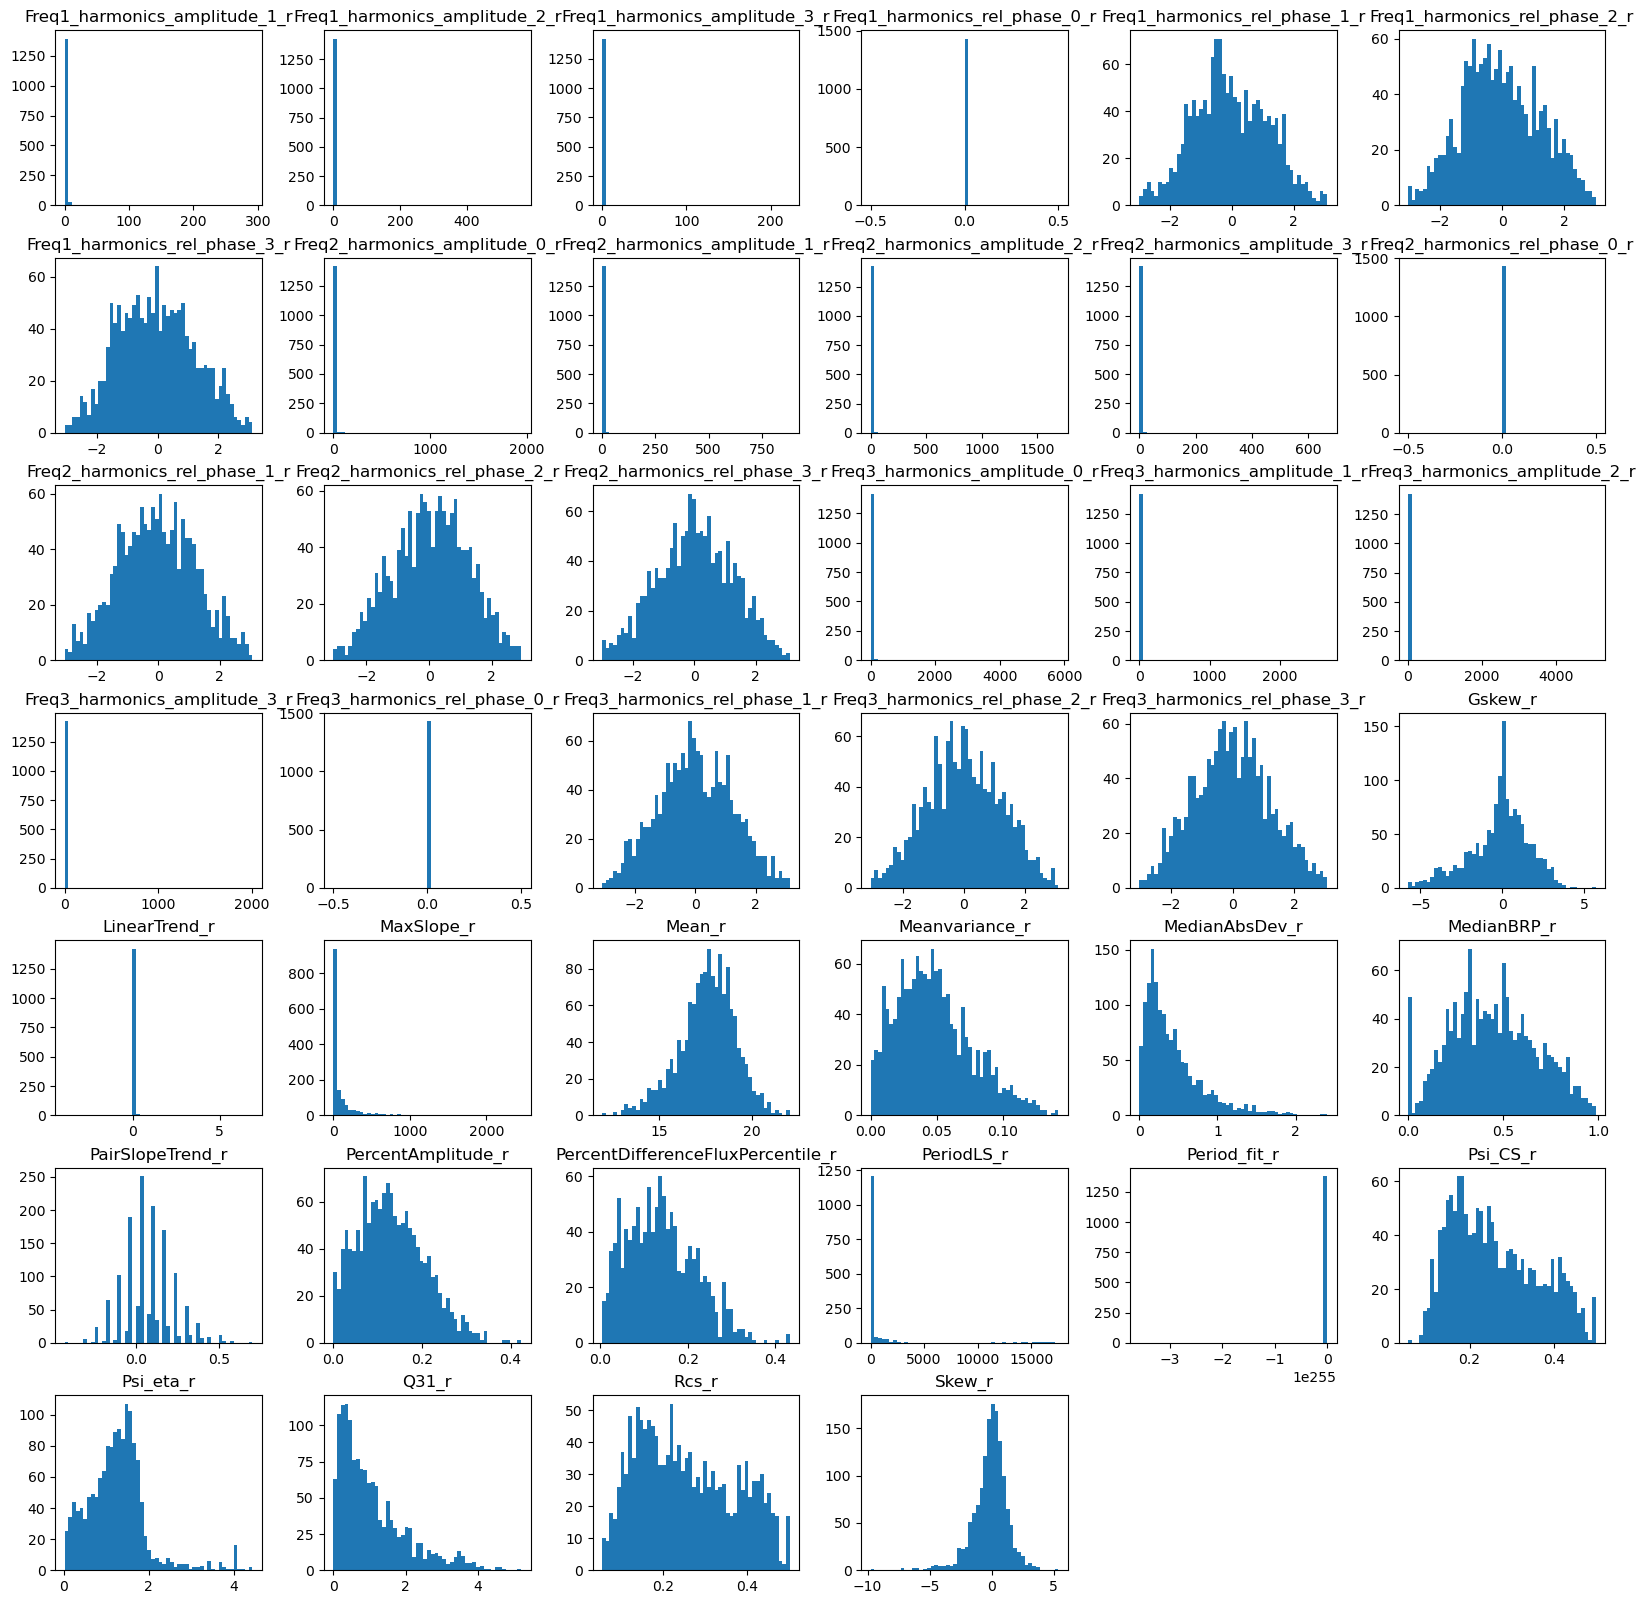

['Freq1_harmonics_amplitude_1_r', 'Freq1_harmonics_amplitude_2_r', 'Freq1_harmonics_amplitude_3_r', 'Freq1_harmonics_rel_phase_0_r', 'Freq1_harmonics_rel_phase_1_r', 'Freq1_harmonics_rel_phase_2_r', 'Freq1_harmonics_rel_phase_3_r', 'Freq2_harmonics_amplitude_0_r', 'Freq2_harmonics_amplitude_1_r', 'Freq2_harmonics_amplitude_2_r', 'Freq2_harmonics_amplitude_3_r', 'Freq2_harmonics_rel_phase_0_r', 'Freq2_harmonics_rel_phase_1_r', 'Freq2_harmonics_rel_phase_2_r', 'Freq2_harmonics_rel_phase_3_r', 'Freq3_harmonics_amplitude_0_r', 'Freq3_harmonics_amplitude_1_r', 'Freq3_harmonics_amplitude_2_r', 'Freq3_harmonics_amplitude_3_r', 'Freq3_harmonics_rel_phase_0_r', 'Freq3_harmonics_rel_phase_1_r', 'Freq3_harmonics_rel_phase_2_r', 'Freq3_harmonics_rel_phase_3_r', 'Gskew_r', 'LinearTrend_r', 'MaxSlope_r', 'Mean_r', 'Meanvariance_r', 'MedianAbsDev_r', 'MedianBRP_r', 'PairSlopeTrend_r', 'PercentAmplitude_r', 'PercentDifferenceFluxPercentile_r', 'PeriodLS_r', 'Period_fit_r', 'Psi_CS_r', 'Psi_eta_r', 'Q3

In [7]:
# Plot feature histograms
import matplotlib.pyplot as plt
import seaborn as sns

df_hist = lc_features_df_imp.copy()

cols = ['ra','dec'] + df_hist.columns.to_list()[16:]
toshow = cols[80:120]

df_hist[toshow].hist(
    bins=50,
    grid = False,
    figsize=(20,20)
)
plt.show()
print(toshow)

### Handle outliers test

### Columns to handle

In [83]:
gaia_skewed = ['ra_error', 'dec_error','parallax_over_error','astrometric_n_obs_ac','astrometric_gof_al','astrometric_chi2_al',
          'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved','astrometric_sigma5d_max',
          'ruwe','phot_g_mean_flux','phot_g_mean_flux_error', 'phot_g_mean_flux_over_error','phot_bp_mean_flux', 
          'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error','phot_rp_mean_flux', 'phot_rp_mean_flux_error', 
          'phot_rp_mean_flux_over_error','phot_bp_rp_excess_factor']

custom_skewed = ['CAR_mean_g','CAR_sigma_g','Eta_e_g','Freq1_harmonics_amplitude_0_g', 'Freq1_harmonics_amplitude_1_g', 
                 'Freq1_harmonics_amplitude_2_g', 'Freq1_harmonics_amplitude_3_g','Freq2_harmonics_amplitude_0_g', 
                 'Freq2_harmonics_amplitude_1_g', 'Freq2_harmonics_amplitude_2_g', 'Freq2_harmonics_amplitude_3_g',
                 'Freq3_harmonics_amplitude_0_g', 'Freq3_harmonics_amplitude_1_g', 'Freq3_harmonics_amplitude_2_g', 
                 'Freq3_harmonics_amplitude_3_g','LinearTrend_g', 'MaxSlope_g','PeriodLS_g', 'Period_fit_g','SlottedA_length_g']

custom_skewed2 = ['CAR_mean_r','CAR_sigma_r','Eta_e_r','Freq1_harmonics_amplitude_0_r', 'Freq1_harmonics_amplitude_1_r',
                    'Freq1_harmonics_amplitude_2_r', 'Freq1_harmonics_amplitude_3_r','Freq2_harmonics_amplitude_0_r',
                    'Freq2_harmonics_amplitude_1_r', 'Freq2_harmonics_amplitude_2_r', 'Freq2_harmonics_amplitude_3_r',
                    'Freq3_harmonics_amplitude_0_r', 'Freq3_harmonics_amplitude_1_r', 'Freq3_harmonics_amplitude_2_r',
                    'Freq3_harmonics_amplitude_3_r','LinearTrend_r', 'MaxSlope_r','PeriodLS_r', 'Period_fit_r','SlottedA_length_r']




### Outlier treatment functions

In [87]:
def outlier_thresholds_normal(dataframe, cols, z_threshold=3):
    
    df = dataframe.copy()

    thresholds = {}

    for col in cols:
        # Upper and lower bounds
        upper_limit = df[col].mean() + z_threshold*df[col].std()
        lower_limit = df[col].mean() - z_threshold*df[col].std()
        thresholds[col] = [upper_limit, lower_limit]

    return thresholds


def outlier_thresholds_skewed(dataframe, cols, iqr_threshold=1.5, upper_limit=None, lower_limit=None):
    df = dataframe.copy()

    thresholds = {}

    for col in cols:
        print(col)
        # Upper and lower bounds
        if upper_limit == None:
            ul = df[col].quantile(0.75) + iqr_threshold*(df[col].quantile(0.75)-df[col].quantile(0.25))
        else:
            ul = upper_limit

        if lower_limit == None:
            ll = df[col].quantile(0.25) - iqr_threshold*(df[col].quantile(0.75)-df[col].quantile(0.25))
        else:
            ll = lower_limit

        thresholds[col] = [ul, ll]
    
    return thresholds

def apply_thresholds(dataframe, cols, thresholds):
    df = dataframe.copy()

    for col in cols:
        # Upper and lower bounds
        upper_limit = thresholds[col][0]
        lower_limit = thresholds[col][1]

        # Ammend value if above the upper limit.
        # np.where parameters are (condition, value if true, value if false)
        df[col] = np.where(df[col]>upper_limit, upper_limit, df[col])
        # Ammend value if below the lower limit
        df[col] = np.where(df[col]<lower_limit, lower_limit, df[col])

    return df


### Handle outliers

In [93]:
ots = outlier_thresholds_skewed(gaia_df, skewed, iqr_threshold=2, upper_limit=None, lower_limit=0)
at = apply_thresholds(gaia_df, skewed, ots)
at

ra_error
dec_error
parallax_over_error
astrometric_n_obs_ac
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_sigma5d_max
ruwe
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_rp_mean_flux
phot_rp_mean_flux_error
phot_rp_mean_flux_over_error
phot_bp_rp_excess_factor


,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,...,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ra_prop,dec_prop,distance,absmag,absmag_bp,absmag_rp
2,ZTF18aabvkix,V1227 Her,UGSU+E,253.496083,20.169556,1,dwarf_nova,dwarf_nova_SU_Uma,NaN,0.0,...,NaN,NaN,NaN,NaN,253.496083,20.169555,768.660740,8.673339,8.824500,8.237304
3,ZTF18aabhjxp,ZTF18aabhjxp,UGZ,89.448833,54.331306,0,dwarf_nova,dwarf_nova_Z_Cam,NaN,0.0,...,0.1436,0.1296,0.1586,MARCS,89.448833,54.331306,2027.469375,4.708795,5.062490,4.114098
9,ZTF20aarfjgo,CY Ori,UGZ,93.703083,9.574389,0,dwarf_nova,dwarf_nova_Z_Cam,NaN,0.0,...,0.0054,0.0016,0.0104,MARCS,93.703084,9.574388,435.146557,4.225089,4.438611,3.814447
12,ZTF20aaklbiy,ASASSN-15ap,UGSU,99.448000,-25.689028,0,dwarf_nova,dwarf_nova_SU_Uma,NaN,0.0,...,NaN,NaN,NaN,NaN,99.448001,-25.689028,1365.991128,9.212041,9.395890,8.615207
13,ZTF17aabungh,V0570 Cas,UGZ/IW,349.114875,59.805056,0,dwarf_nova,dwarf_nova_Z_Cam,dwarf_nova_Z_Cam_IW_And,0.0,...,0.0010,0.0002,0.0027,MARCS,349.114875,59.805055,775.742473,5.121122,5.347558,4.737121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Handle missing values based on data in other columns

### Feature plots

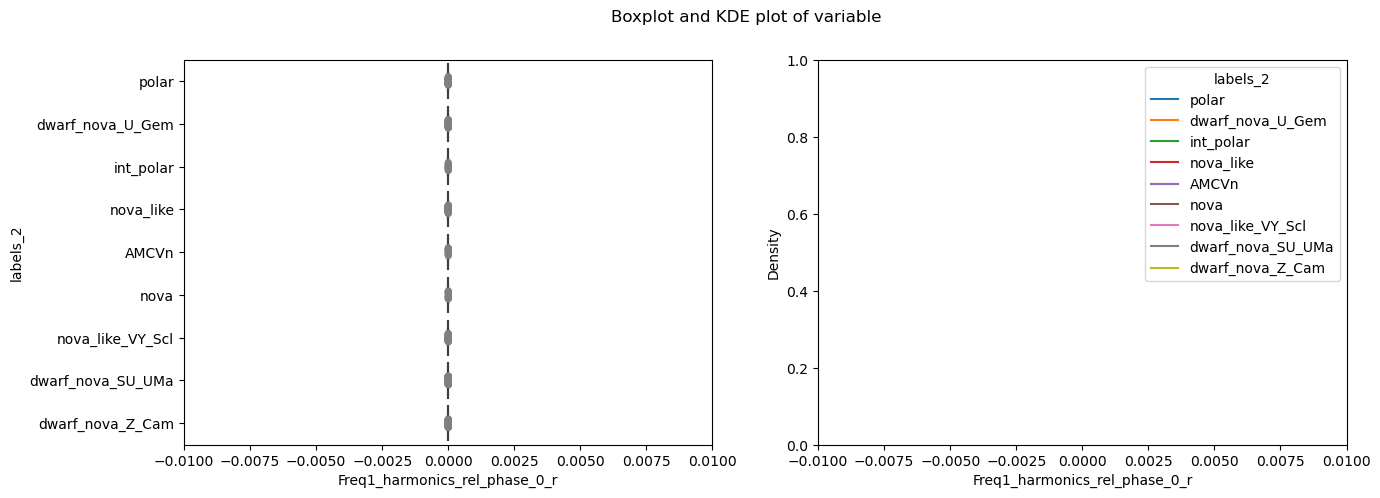

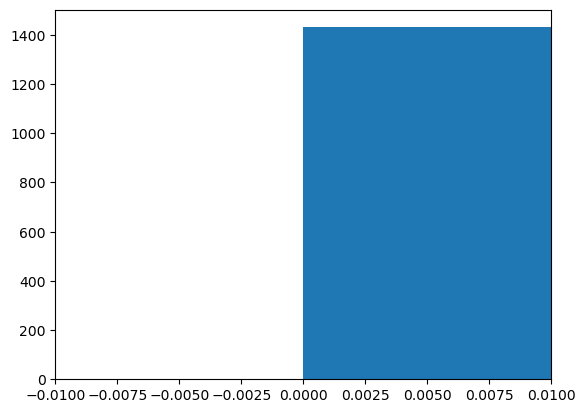

<Figure size 500x300 with 0 Axes>

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
dataframe = lc_features_df
name = 'Freq1_harmonics_rel_phase_0_r'
limits = (-0.01,0.01)
labels = 'labels_2'

droplist = ['Eta_e_r','Freq3_harmonics_rel_phase_3_r','Freq3_harmonics_rel_phase_1_g','Freq1_harmonics_rel_phase_2_r',
            'Freq1_harmonics_rel_phase_3_r','Freq2_harmonics_rel_phase_2_g','Freq3_harmonics_rel_phase_2_r',]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Boxplot and KDE plot of variable')

sns.boxplot(ax=axes[0], data=dataframe, x=name, y=labels)
sns.stripplot(ax=axes[0], data=dataframe, x=name, y=labels, color='grey', alpha=0.5)
axes[0].set(xlim=limits)
sns.kdeplot(ax=axes[1], x=name, data=dataframe, hue=labels, common_norm=False)
axes[1].set(xlim=limits)
plt.show()


# dataframe[name].hist(bins=75, grid=False,figsize=(5,3))
plt.hist(dataframe[name], bins=100)
plt.xlim(limits)
plt.figure(figsize=(5,3))

plt.show()

### Get mutual information, VIF and ANOVA scores

In [134]:
# Get mutual information scores for g band light curve features
# from filtermethods import mutual_info_scores
from filtermethods import FilterMethods
from sklearn import preprocessing
from sklearn.impute import KNNImputer

# From Gaia features dataframe drop rows without a Gaia counterpart.
X = gaia_df.copy()
X = X.dropna(subset=['ra_error']).reset_index(drop=True)

# Get labels
le = preprocessing.LabelEncoder()
le.fit(X[label_scheme])
y = le.transform(X[label_scheme])

# Define X. Drop columns non-numeric types and columns with high missing values
X = pd.concat([X[['ra','dec']], X.iloc[:,16:]], axis=1)
X = X[X.dtypes[X.dtypes != 'object'].index]
X = X.dropna(thresh=X.shape[0]*0.70,axis=1)

# Drop columns that convey the same information as other columns
droplist = ['phot_rp_mean_flux','phot_bp_mean_flux','classprob_dsc_combmod_galaxy','phot_g_mean_flux','classprob_dsc_combmod_star',
            'classprob_dsc_combmod_quasar']
X = X.drop(columns=droplist)
print(X.shape)
print(X.isnull().sum())

fm = FilterMethods(X, y)

# Get mutual information scores
mi = fm.mutual_info(KNNImputer(n_neighbors=5, 
                               weights='distance', 
                               metric='nan_euclidean', 
                               keep_empty_features=True)).sort_values(by='mutual_info_score', ascending=False)

# Get ANOVA scores
anova = fm.anova_oneway()

# Get VIF scores
vif = fm.calc_vif(imputer=KNNImputer(n_neighbors=5,
                                     weights='distance', 
                                     metric='nan_euclidean', 
                                     keep_empty_features=True))

# Get VIF scores with threshold reduction
vif10 = fm.vif_threshold_reduction(threshold=5,imputer=KNNImputer(n_neighbors=5, 
                                                                   weights='distance', 
                                                                   metric='nan_euclidean', 
                                                                   keep_empty_features=True))

# Get mutual information scores for r band light curve features

# Get mutual information scores for gaia features

# Get ANOVA scores for g band light curve features

# Get ANOVA scores for r band light curve features

# Get ANOVA scores for gaia features

(1269, 83)
ra                                   0
dec                                  0
ra_error                             0
dec_error                            0
parallax                            73
parallax_error                      73
parallax_over_error                 73
pm                                  73
pmra                                73
pmra_error                          73
pmdec                               73
pmdec_error                         73
ra_dec_corr                          0
ra_parallax_corr                    73
ra_pmra_corr                        73
ra_pmdec_corr                       73
dec_parallax_corr                   73
dec_pmra_corr                       73
dec_pmdec_corr                      73
parallax_pmra_corr                  73
parallax_pmdec_corr                 73
pmra_pmdec_corr                     73
astrometric_n_obs_al                 0
astrometric_n_obs_ac                 0
astrometric_n_good_obs_al            0
astrometric_n_

In [148]:
mi

,features,mutual_info_score,mutual_info_score_rank
82,absmag_rp,0.361409,1
80,absmag,0.328562,2
81,absmag_bp,0.316213,3
62,phot_rp_mean_mag,0.171210,4
52,phot_g_mean_flux_error,0.166319,5
79,distance,0.162568,6
4,parallax,0.162025,7
58,phot_bp_mean_mag,0.161218,8
2,ra_error,0.158727,9
54,phot_g_mean_mag,0.148284,10


In [136]:
fm2= FilterMethods(X.drop(columns=vif10['feature']), y)
fm2.calc_vif(KNNImputer(n_neighbors=5,
                                     weights='distance', 
                                     metric='nan_euclidean', 
                                     keep_empty_features=True)).sort_values(by='VIF', ascending=False)

,variables,VIF
22,new_matched_transits,4.357549
40,ecl_lon,4.031195
20,astrometric_params_solved,3.898401
25,ipd_gof_harmonic_phase,3.701439
3,pm,3.518258
9,ra_pmdec_corr,3.158825
11,dec_pmra_corr,3.131155
19,astrometric_excess_noise,2.973651
34,phot_bp_rp_excess_factor,2.805208
2,parallax_over_error,2.740145


In [120]:
anova.sort_values(by='p_value', ascending=True)

,features,F_test_stat,p_value
80,absmag,163.725517,6.602901e-184
82,absmag_rp,162.368024,8.310190e-183
81,absmag_bp,157.222740,1.357709e-178
62,phot_rp_mean_mag,61.560205,5.096297e-85
54,phot_g_mean_mag,57.685152,3.456946e-80
58,phot_bp_mean_mag,52.598326,9.870085e-74
4,parallax,32.249200,4.148763e-46
11,pmdec_error,26.661445,3.257237e-38
5,parallax_error,25.791031,5.773782e-37
9,pmra_error,25.562231,1.231708e-36
